In [9]:
import pyemu
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import matplotlib.pyplot as plt
import psutil
import shutil
import numpy as np
import sys

In [10]:
sys.path.insert(1, 'D:/spark/gits/apexmf')

In [3]:
from apexmf import apexmf_pst_viz
from apexmf.salt.salt_handler import SaltAnalysis
from apexmf.salt.analyzer import SaltAnalysis, SaltViz, get_stats

In [4]:
wd = "D:/spark/upgreen_amrs"
os.chdir(wd)

In [5]:
t_d = os.path.join(wd, "upgreen_amrs")

In [7]:
# test run
pyemu.os_utils.run("pestpp-ies upgreen_amrs_pp.pst",cwd=t_d)

In [11]:
# reweight
pst = pyemu.Pst(os.path.join(t_d,'upgreen_amrs_pp.pst'))
pst.phi


45930626266691.81

# Reweight

In [12]:
balanced_groups = {grp:10000000 for grp in pst.nnz_obs_groups}
# print(pst.phi) #assumes "my.res" is colocated with "my.pst"
pst.adjust_weights(obsgrp_dict=balanced_groups)

In [13]:
os.getcwd()

'D:\\spark\\upgreen_amrs'

In [14]:
obs = pst.observation_data.copy()
obs.to_csv('test_obs.csv')

In [12]:
pst.write(os.path.join(t_d,'upgreen_amrs_pp_rw.pst'))

noptmax:0, npar_adj:180, nnz_obs:2127


# Prior

In [ ]:
'''
pst.pestpp_options['ies_num_reals'] = 100
pst.control_data.noptmax = -1
pst.write(os.path.join(template_ws,"dolores_amrs_pp_rw_prior.pst"))
'''

In [11]:
pyemu.os_utils.start_workers?

In [6]:
num_workers = psutil.cpu_count(logical=False)

In [12]:
m_d = os.path.join('main_diagonal_pp_rw_prior_mc')

In [14]:
os.getcwd()


'D:\\spark\\upgreen_amrs'

In [15]:
t_d

'D:/spark/upgreen_amrs\\upgreen_amrs'

In [13]:
pyemu.os_utils.start_workers(
                        t_d, # the folder which contains the "template" PEST dataset
                        'pestpp-ies', #the PEST software version we want to run
                        'animas_amrs_pp_rw_prior.pst', # the control file to use with PEST
                        num_workers=num_workers, #how many agents to deploy
                        worker_root='.', #where to deploy the agent directories; relative to where python is running
                        master_dir=m_d, #the manager directory
                        reuse_master=True,     
                            )

Exception: pst_rel_path not found from worker_dir

In [9]:
pst = pyemu.Pst(os.path.join(m_d,'animas_amrs_pp_rw_prior.pst'))

In [10]:
pr_oe = pyemu.ObservationEnsemble.from_csv(
    pst=pst,filename=os.path.join(m_d,"animas_amrs_pp_rw_prior.0.obs.csv")
    )
# pt_oe = pyemu.ObservationEnsemble.from_csv(pst=pst,filename=os.path.join(m_d,"animas_amrs_rw_pp.{0}.obs.csv".format(pst.control_data.noptmax)))


In [ ]:
pyemu.plot_utils.res_1to1(pst);

In [13]:
def plot_tseries_prior_ensembles(pr_oe, dot=True):
    pst.try_parse_name_metadata()
    # get the observation data from the control file and select 
    obs = pst.observation_data.copy()
    obs = obs.loc[obs.obgnme.apply(lambda x: x in pst.nnz_obs_groups),:]
    # --- time control ---
    time_col = []
    for i in range(len(obs)):
        if obs.iloc[i, 0][0] == "g":
            time_col.append(obs.iloc[i, 0][-8:])
        else:
            time_col.append(obs.iloc[i, 0][-6:])
    obs['time'] = time_col
    # ---------------------
    ogs = obs.obgnme.unique()
    fig,axes = plt.subplots(len(ogs),1,figsize=(10,4*len(ogs)))
    ogs.sort()
    # for each observation group (i.e. timeseries)
    for ax,og in zip(axes,ogs):
        # get values for x axis
        oobs = obs.loc[obs.obgnme==og,:].copy()
        oobs.loc[:,"time"] = oobs.time.astype(str)
#         oobs.sort_values(by="time",inplace=True)
        tvals = oobs.time.values
        onames = oobs.obsnme.values
        if dot is True:
            # plot prior
            [ax.scatter(tvals,pr_oe.loc[i,onames].values,color="gray",s=30, alpha=0.2) for i in pr_oe.index]
            # plot posterior
#             [ax.scatter(tvals,pt_oe.loc[i,onames].values,color='b',s=30,alpha=0.2) for i in pt_oe.index]
            # plot measured+noise 
            oobs = oobs.loc[oobs.weight>0,:]
            tvals = oobs.time.values
            onames = oobs.obsnme.values
    #         [ax.plot(tvals,noise.loc[i,onames].values,"r",lw=0.5,alpha=0.5) for i in noise.index]
            ax.scatter(oobs.time,oobs.obsval,color='red',s=30).set_facecolor("none")
        if dot is False:
            # plot prior
            [ax.plot(tvals,pr_oe.loc[i,onames].values,"0.5",lw=0.5,alpha=0.5) for i in pr_oe.index]
            # plot posterior
#             [ax.plot(tvals,pt_oe.loc[i,onames].values,"b",lw=0.5,alpha=0.5) for i in pt_oe.index]
            # plot measured+noise 
            oobs = oobs.loc[oobs.weight>0,:]
            tvals = oobs.time.values
            onames = oobs.obsnme.values
    #         [ax.plot(tvals,noise.loc[i,onames].values,"r",lw=0.5,alpha=0.5) for i in noise.index]
            ax.plot(oobs.time,oobs.obsval,"r-",lw=2)
        ax.tick_params(axis='x', labelrotation=90)
        ax.margins(x=0.01)
        ax.set_title(og,loc="left")
    fig.tight_layout()
    return fig    

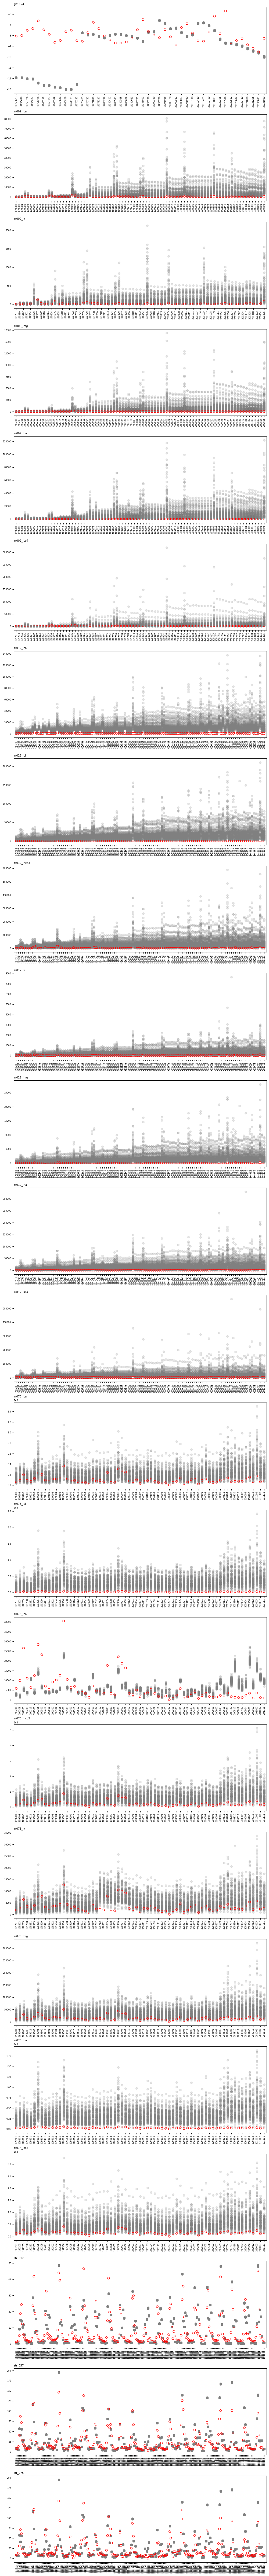

In [14]:
fig = plot_tseries_prior_ensembles(pr_oe, dot=True)

# Posterior

In [16]:
m_d = os.path.join('main_ies_1_pp_rw_ies')

In [17]:
pyemu.os_utils.start_workers(t_d, # the folder which contains the "template" PEST dataset
                            'pestpp-ies', #the PEST software version we want to run
                            'upgreen_amrs_pp_rw_ies.pst', # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory
                            reuse_master=True,
                            )

In [18]:
pst = pyemu.Pst(os.path.join(m_d,'upgreen_amrs_pp_rw_ies.pst'))

In [19]:
pr_oe = pyemu.ObservationEnsemble.from_csv(
    pst=pst,filename=os.path.join(m_d,"upgreen_amrs_pp_rw_ies.0.obs.csv")
    )
pt_oe = pyemu.ObservationEnsemble.from_csv(pst=pst,filename=os.path.join(m_d,"upgreen_amrs_pp_rw_ies.{0}.obs.csv".format(pst.control_data.noptmax)))


<Figure size 800x1050 with 0 Axes>

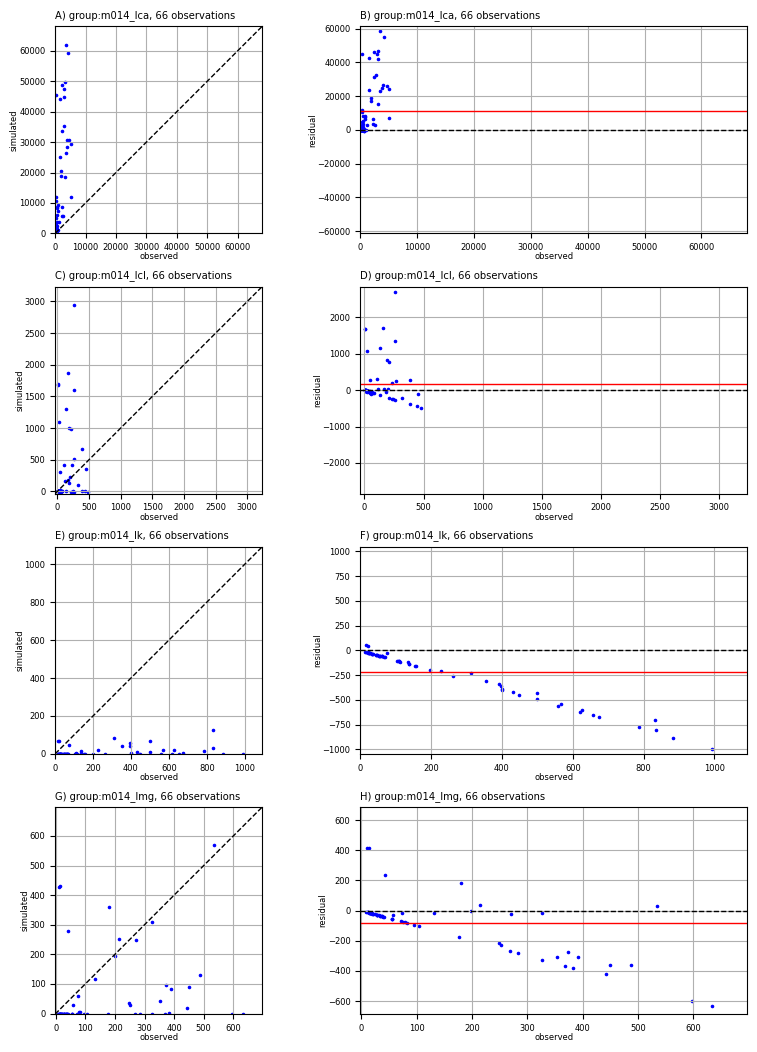

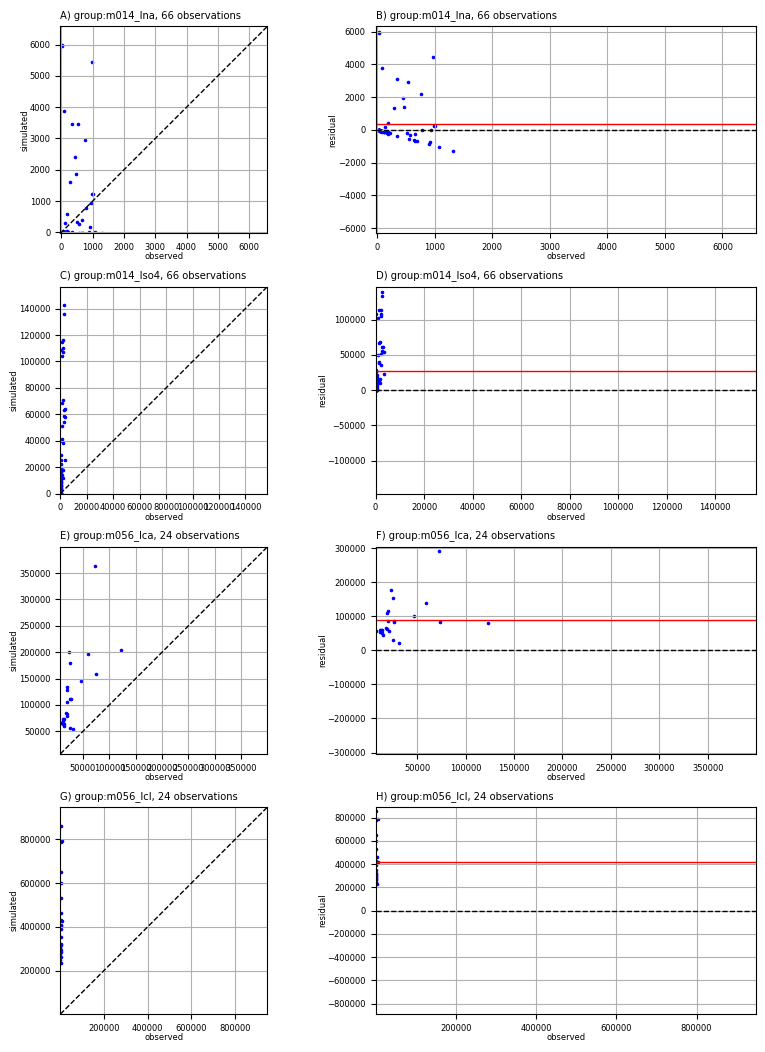

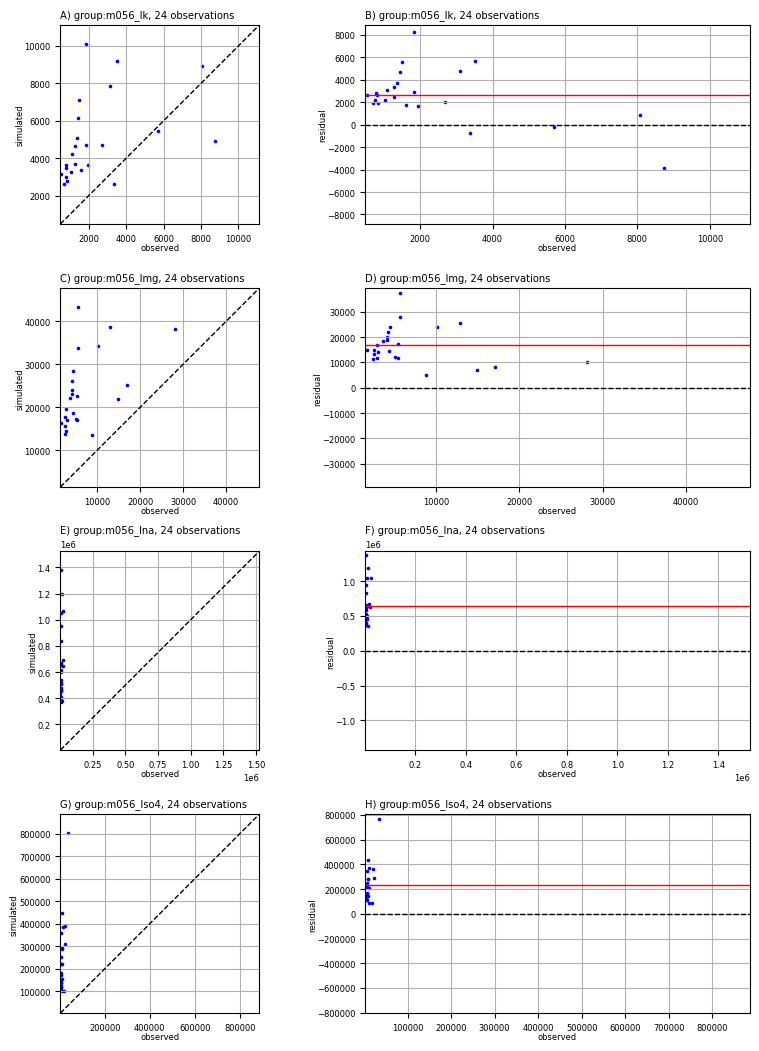

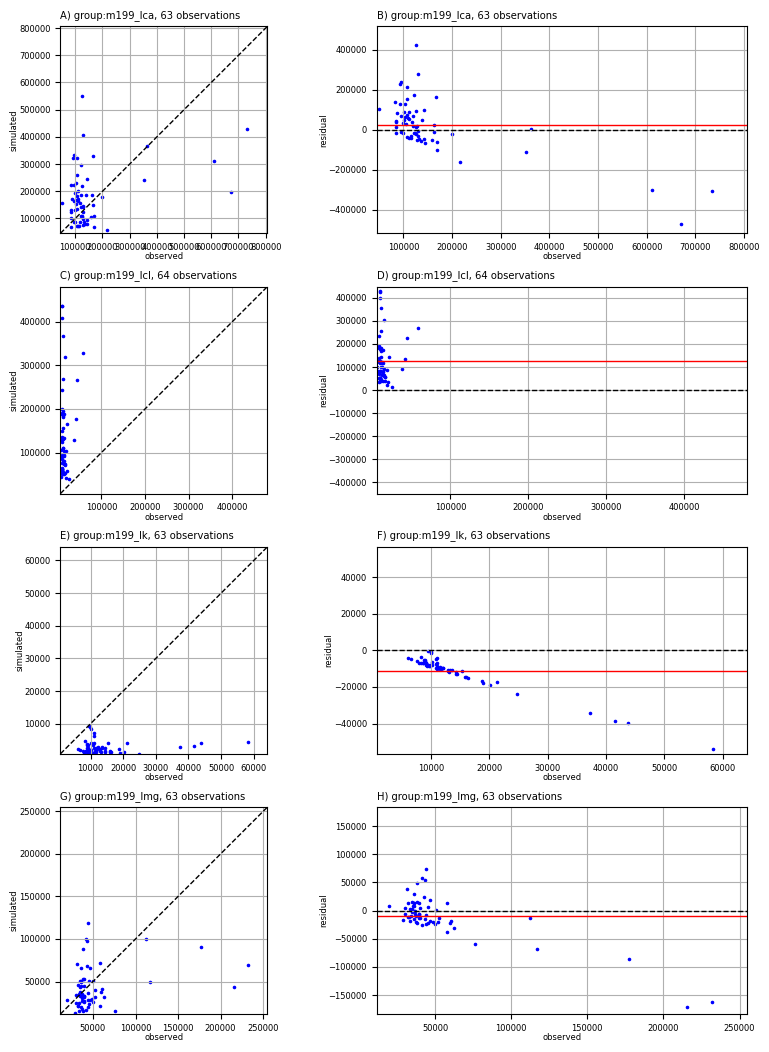

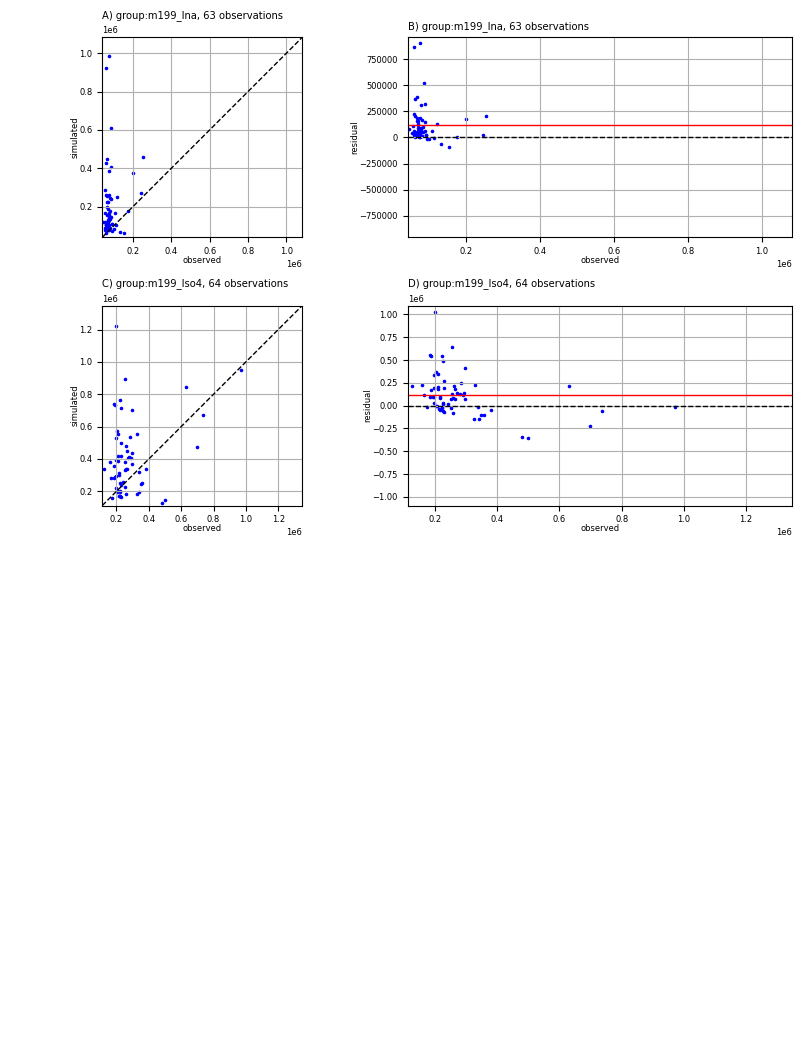

In [20]:
pyemu.plot_utils.res_1to1(pst);

In [22]:
pt_oe.phi_vector

real_name
1       1.771438e+08
2       1.436726e+08
3       1.561914e+08
4       1.660472e+08
5       1.416774e+08
            ...     
292     1.667561e+08
294     1.445241e+08
297     1.729136e+08
298     1.642816e+08
base    1.581820e+08
Length: 84, dtype: float64

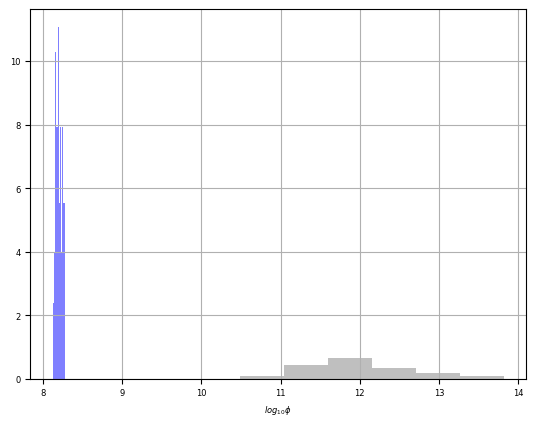

In [26]:
fig,ax = plt.subplots(1,1)
pr_oe.phi_vector.apply(np.log10).hist(ax=ax,fc="0.5",ec="none",alpha=0.5,density=True)
pt_oe.phi_vector.apply(np.log10).hist(ax=ax,fc="b",ec="none",alpha=0.5,density=True)
_ = ax.set_xlabel("$log_{10}\\phi$")

In [24]:
def plot_tseries_ensembles(
                    pr_oe, pt_oe, dot=True,
#                     onames=["hds","sfr"]
                    ):
    pst.try_parse_name_metadata()
    # get the observation data from the control file and select 
    obs = pst.observation_data.copy()
    obs = obs.loc[obs.obgnme.apply(lambda x: x in pst.nnz_obs_groups),:]
    time_col = []
    for i in range(len(obs)):
        time_col.append(obs.iloc[i, 0][-6:])
    obs.time = time_col
#     # onames provided in oname argument
#     obs = obs.loc[obs.oname.apply(lambda x: x in onames)]
    # only non-zero observations
#     obs = obs.loc[obs.obgnme.apply(lambda x: x in pst.nnz_obs_groups),:]
    # make a plot
    ogs = obs.obgnme.unique()
    fig,axes = plt.subplots(len(ogs),1,figsize=(10,4*len(ogs)))
    ogs.sort()
    # for each observation group (i.e. timeseries)
    for ax,og in zip(axes,ogs):
        # get values for x axis
        oobs = obs.loc[obs.obgnme==og,:].copy()
        oobs.loc[:,"time"] = oobs.time.astype(str)
#         oobs.sort_values(by="time",inplace=True)
        tvals = oobs.time.values
        onames = oobs.obsnme.values
        if dot is True:
            # plot prior
            [ax.scatter(tvals,pr_oe.loc[i,onames].values,color="gray",s=30, alpha=0.5) for i in pr_oe.index]
            # plot posterior
            [ax.scatter(tvals,pt_oe.loc[i,onames].values,color='b',s=30,alpha=0.2) for i in pt_oe.index]
            # plot measured+noise 
            oobs = oobs.loc[oobs.weight>0,:]
            tvals = oobs.time.values
            onames = oobs.obsnme.values
    #         [ax.plot(tvals,noise.loc[i,onames].values,"r",lw=0.5,alpha=0.5) for i in noise.index]
            ax.scatter(oobs.time,oobs.obsval,color='red',s=30).set_facecolor("none")
        if dot is False:
            # plot prior
            [ax.plot(tvals,pr_oe.loc[i,onames].values,"0.5",lw=0.5,alpha=0.5) for i in pr_oe.index]
            # plot posterior
            [ax.plot(tvals,pt_oe.loc[i,onames].values,"b",lw=0.5,alpha=0.5) for i in pt_oe.index]
            # plot measured+noise 
            oobs = oobs.loc[oobs.weight>0,:]
            tvals = oobs.time.values
            onames = oobs.obsnme.values
    #         [ax.plot(tvals,noise.loc[i,onames].values,"r",lw=0.5,alpha=0.5) for i in noise.index]
            ax.plot(oobs.time,oobs.obsval,"r-",lw=2)
        ax.tick_params(axis='x', labelrotation=90)
        ax.margins(x=0.01)
        ax.set_title(og,loc="left")
    fig.tight_layout()
    return fig

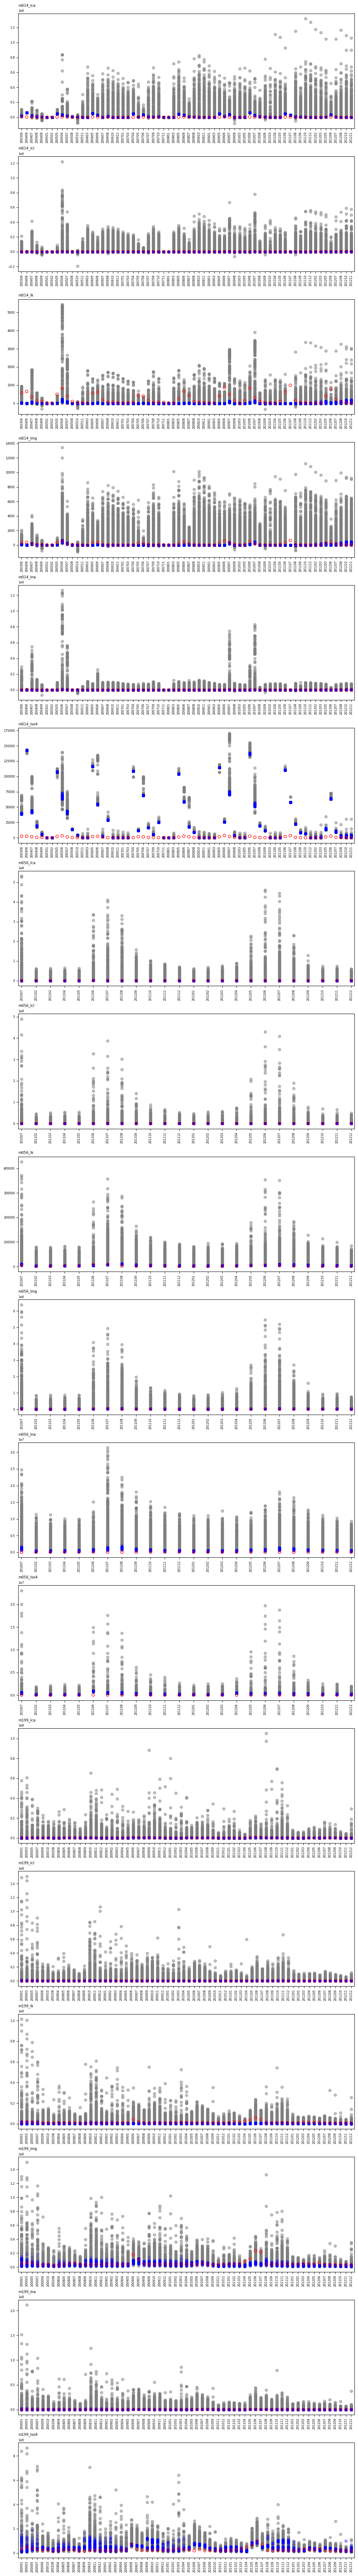

In [25]:
fig = plot_tseries_ensembles(pr_oe, pt_oe, dot=True)

In [26]:
os.getcwd()

'D:\\spark\\animas_amrs'

In [30]:
pst.parrep(parfile=os.path.join(m_d, 'dolores_amrs_pp_rw_ies.7.base.par'))

Updating parameter values from main_ies_1_pp_rw_ies\dolores_amrs_pp_rw_ies.7.base.par
parrep: updating noptmax to 0


In [31]:
# updates the model input files with parameter values
pst.write_input_files(pst_path=m_d)

In [32]:
m_d

'main_ies_1_pp_rw_ies'

In [33]:
# run the model forward run; this applies all the multipler paarameters, executes MODFLOW6 and MODPATH7 and then postprocess observations
os.chdir(m_d)
pyemu.os_utils.run('python salt_forward_run.py')

In [32]:
os.getcwd()

'D:\\spark\\animas_amrs\\main_ies_1_pp_rw_ies'

In [38]:
def salt_viz(model, salt_df, subs):
    for i in subs:
        print(f"{'= = '*3}sub{i:03d} {'= = '*3}")
        sim_df = model.read_salt_sim_cha(salt_df, i, sim_start, cal_start, cal_end).resample('M').mean()
        obd_df = model.read_salt_obd_cha(i, time_step='mon')
        obd_df = obd_df[~obd_df.index.duplicated(keep='first')]    
        for o in obd_df.columns:
            comdf = model.sim_obd_df(sim_df, o, obd_df, o)
            print(o)
            print(get_stats(comdf['1/1/1992':'12/31/2011']))
            fig, ax = plt.subplots(1, 2, figsize=(12, 2), gridspec_kw={'width_ratios': [6, 1]})
            SaltViz(comdf['1/1/1992':'12/31/2011']).hydro_sim_obd02(ax[0])
            SaltViz(comdf['1/1/1992':'12/31/2011']).reg_line02(ax[1])
            fig.tight_layout()
            plt.show()

In [39]:
m_test = SaltAnalysis(os.getcwd())
salt_test = m_test.load_salt_cha_result()
sim_start = '1/1/1987'
cal_start = '1/1/1992'
cal_end = '12/31/2011'

In [41]:
salt_test

load_so4     load_ca      load_mg      load_na      load_k   
subarea                                                                  
1            0.00000     0.00000     0.000000      0.00000    0.000000  \
2            0.00000     0.00000     0.000000      0.00000    0.000000   
3            0.00000     0.00000     0.000000      0.00000    0.000000   
4            0.00000     0.00000     0.000000      0.00000    0.000000   
5            0.00000     0.00000     0.000000      0.00000    0.000000   
...              ...         ...          ...          ...         ...   
155      15118.79600  3665.69410  1601.367400  15230.84700  799.208800   
156      14187.06900  3429.47410  1517.290300  14263.23500  751.031740   
157      14158.77300  3422.67380  1515.032200  14238.01700  749.833620   
158        728.79114   191.59772    69.017715    806.62427   40.890106   
159        664.95490   175.96190    63.859802    748.57300   38.106602   

             load_cl  load_co3  load_hco3    conc_so4    conc_ca     conc_mg   
subarea                                                                        
1            0.00000  0.000000   0.000000     0.00000    0.00000    0.000000  \
2            0.00000  0.000000   0.000000     0.00000    0.00000    0.000000   
3            0.00000  0.000000   0.000000     0.00000    0.00000    0.000000   
4            0.00000  0.000000   0.000000     0.00000    0.00000    0.000000   
5            0.00000  0.000000   0.000000     0.00000    0.00000    0.000000   
...              ...       ...        ...         ...        ...         ...   
155      25797.78300  0.008430   0.008430   539.82312  130.88518   57.177509   
156      24775.74400  0.008362   0.008362   522.03894  126.19372   55.831448   
157      24746.59800  0.008362   0.008362   522.22382  126.23988   55.879555   
158        813.77258  0.000067   0.000067  1685.70870  443.16943  159.639390   
159        747.89807  0.000066   0.000066   577.04596  152.69925   55.417355   

            conc_na     conc_k     conc_cl  conc_co3  conc_hco3  
subarea                                                          
1           0.00000   0.000000     0.00000  0.000000   0.000000  
2           0.00000   0.000000     0.00000  0.000000   0.000000  
3           0.00000   0.000000     0.00000  0.000000   0.000000  
4           0.00000   0.000000     0.00000  0.000000   0.000000  
5           0.00000   0.000000     0.00000  0.000000   0.000000  
...             ...        ...         ...       ...        ...  
155       543.82391  28.536093   921.12097  0.000301   0.000301  
156       524.84161  27.635576   911.66846  0.000308   0.000308  
157       525.14661  27.656420   912.73889  0.000308   0.000308  
158      1865.73830  94.579651  1882.27260  0.000154   0.000154  
159       649.60950  33.068802   649.02380  0.000058   0.000058  

[1451829 rows x 16 columns]

In [40]:
salt_viz(m_test, salt_test, [38])

= = = = = = sub038 = = = = = = 


KeyError: 'Discharge'

In [ ]:
# wd = 'D:/Projects/Watersheds/White/Analysis/APEX-MODFLOWs/calibration/v02_calibrated'
os.chdir(t_d)
str_dic = {12:'str_012', 57:'str_057', 75:'str_075'}
for sim, obd in str_dic.items():
    pdf = apexmf_pst_viz.stf_df('SITE75.RCH', '1/1/1987', sim, obd, time_step='M')
    apexmf_pst_viz.stf_plot(pdf['1/1/1992':'12/31/2011'])
#     apexmf_pst_viz.str_plot(pdf['1/1/2010':'12/31/2019'])
mf_dic = {5895:'wt_gw_124'}
for sim, obd in mf_dic.items():
    mfdf = apexmf_pst_viz.wt_df('1/1/1987', sim, obd, prep_sub=75)
    # apexmf_pst_viz.wt_plot(mfdf['1/1/2010':'12/31/2019'])
    apexmf_pst_viz.wt_plot(mfdf['1/1/1992':'12/31/2011'])